In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
#use_python("/home/vsevim/software/anaconda3/envs/R42/bin/python")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"

    # prj_name = "Screen2_101vecs"
    # # data_subdir_suffixes = "L1,L2,L3,L4"     
    # secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    # save_seurat_h5 = "NO"
}


In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated_wo_guide_calls.h5seurat")
updated_integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated.h5seurat")
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [6]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

Skipping guides with less than 50 counts
Running Lib_1 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE6-2b 39 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_1 
Running Lib_2 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_2 
Running Lib_3 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_3 


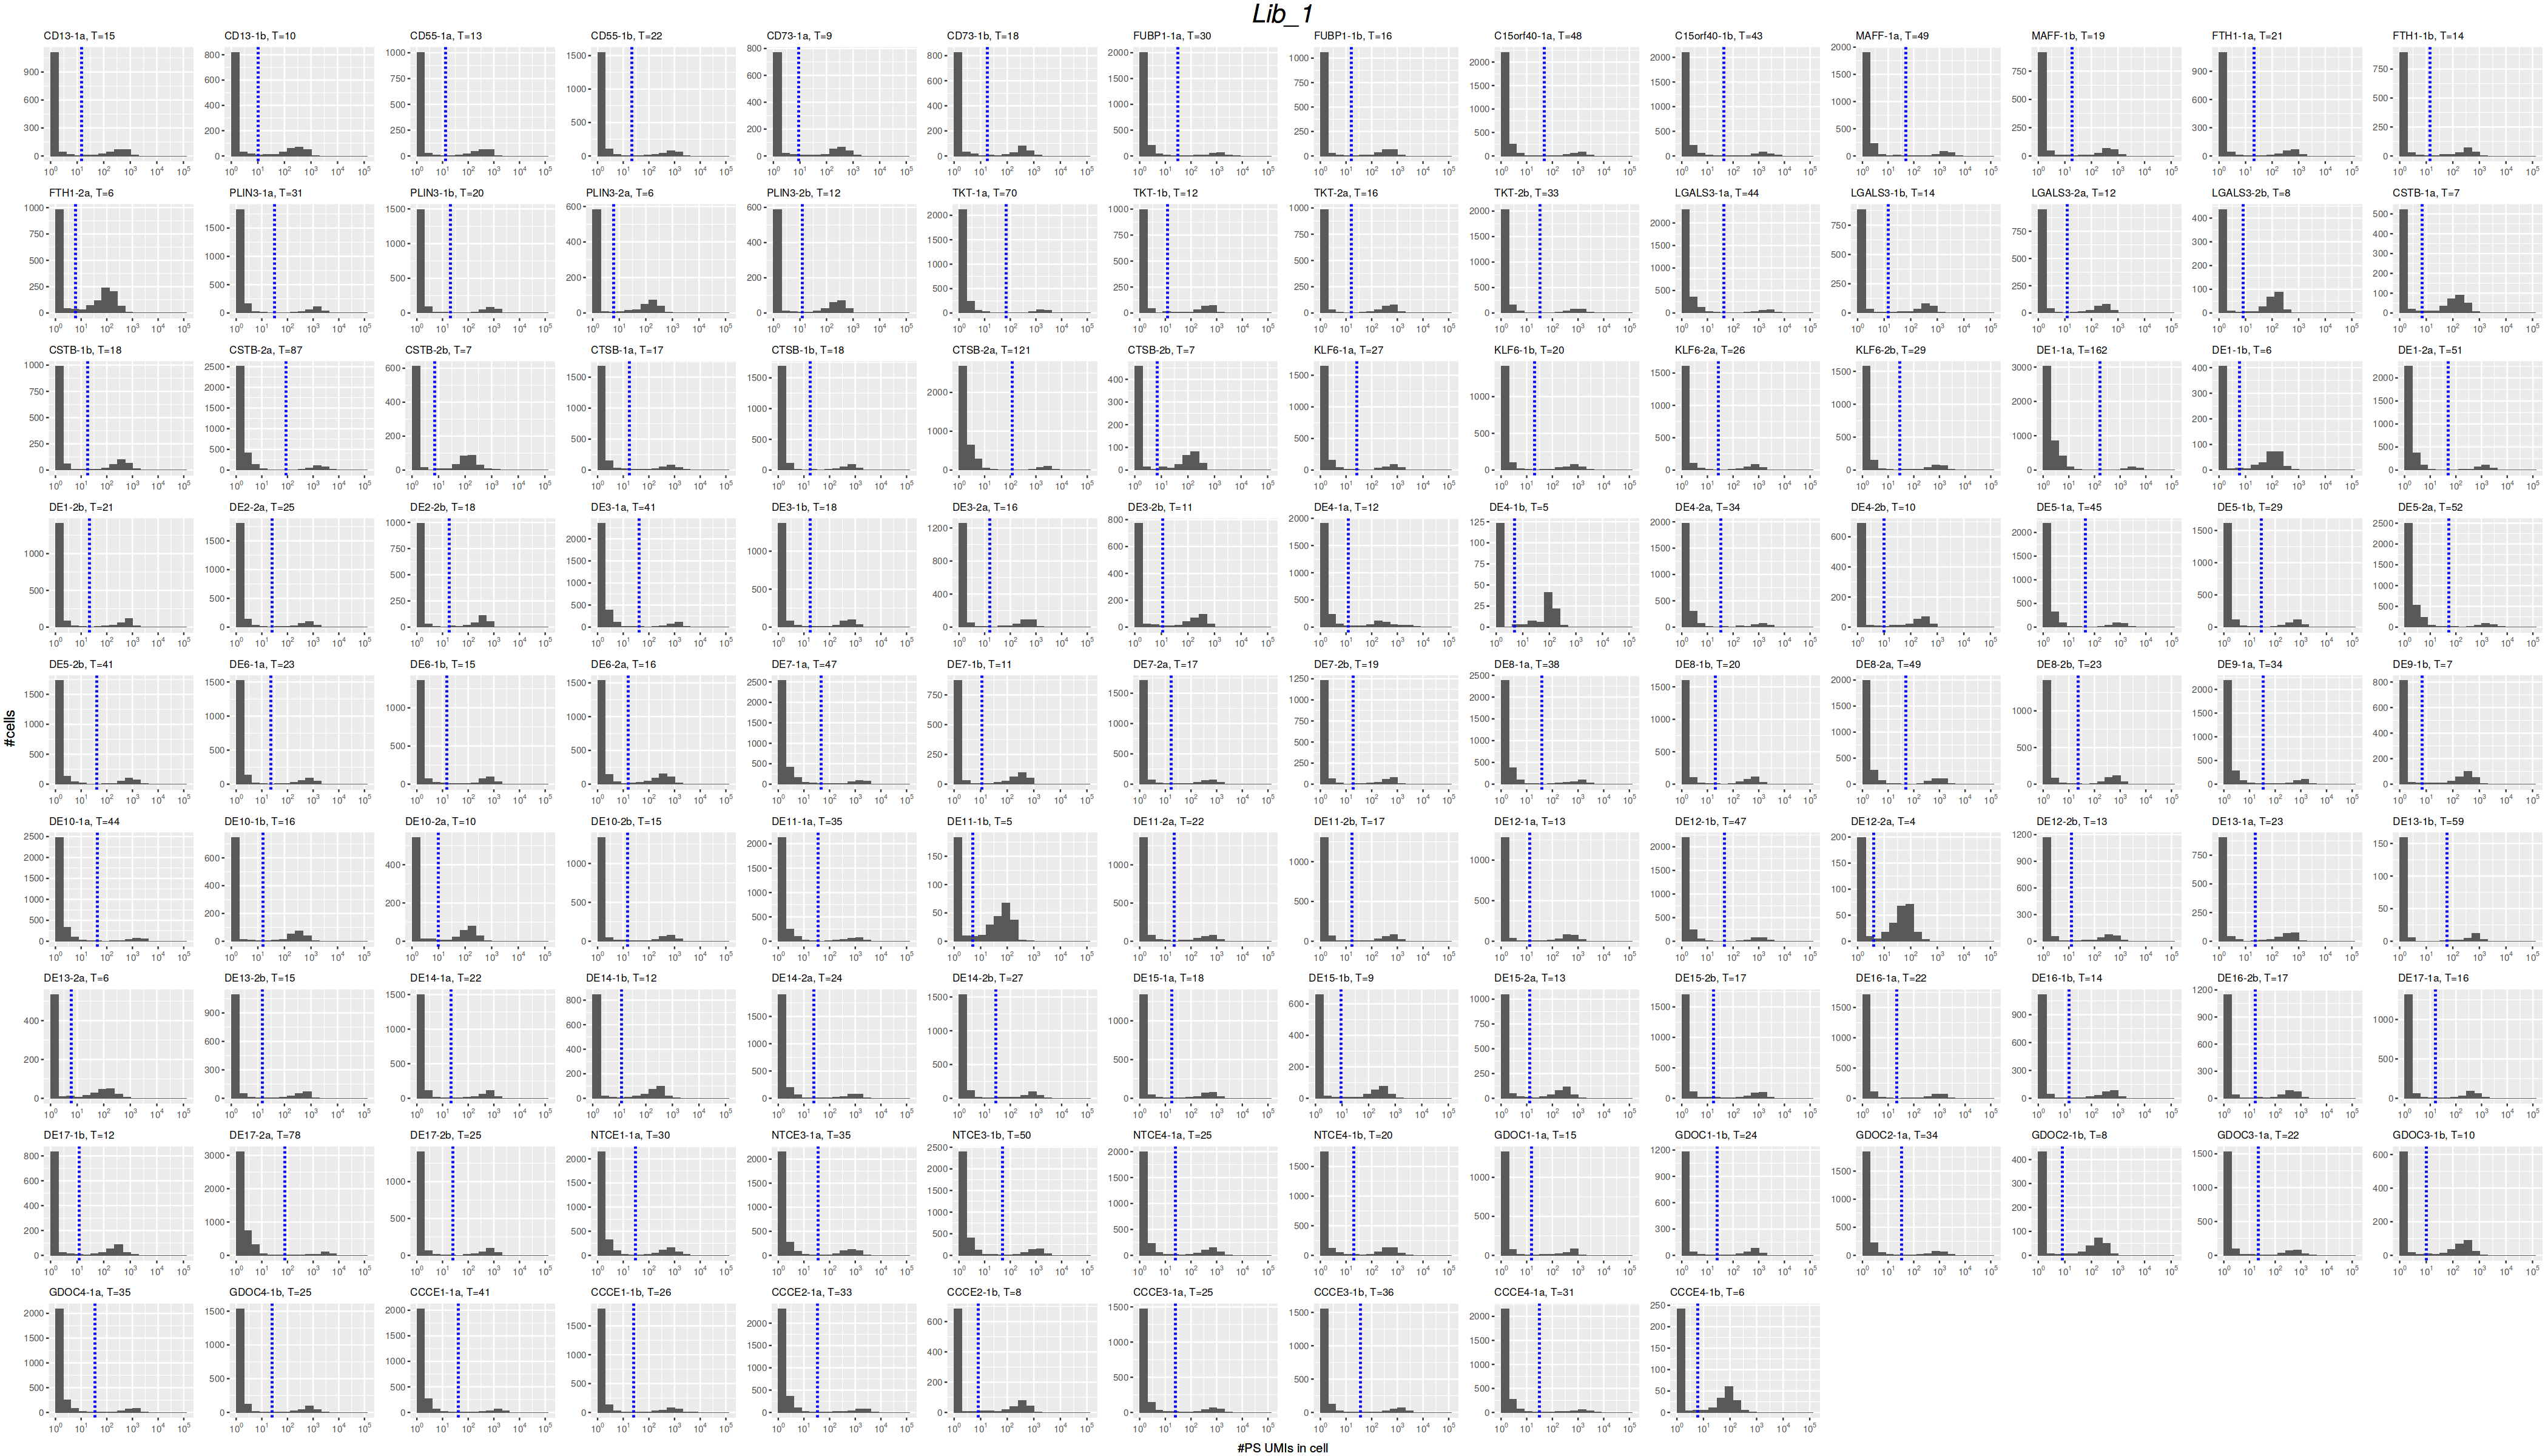

Running Lib_4 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 1 guides found
Skipping DE2-1b 1 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_4 


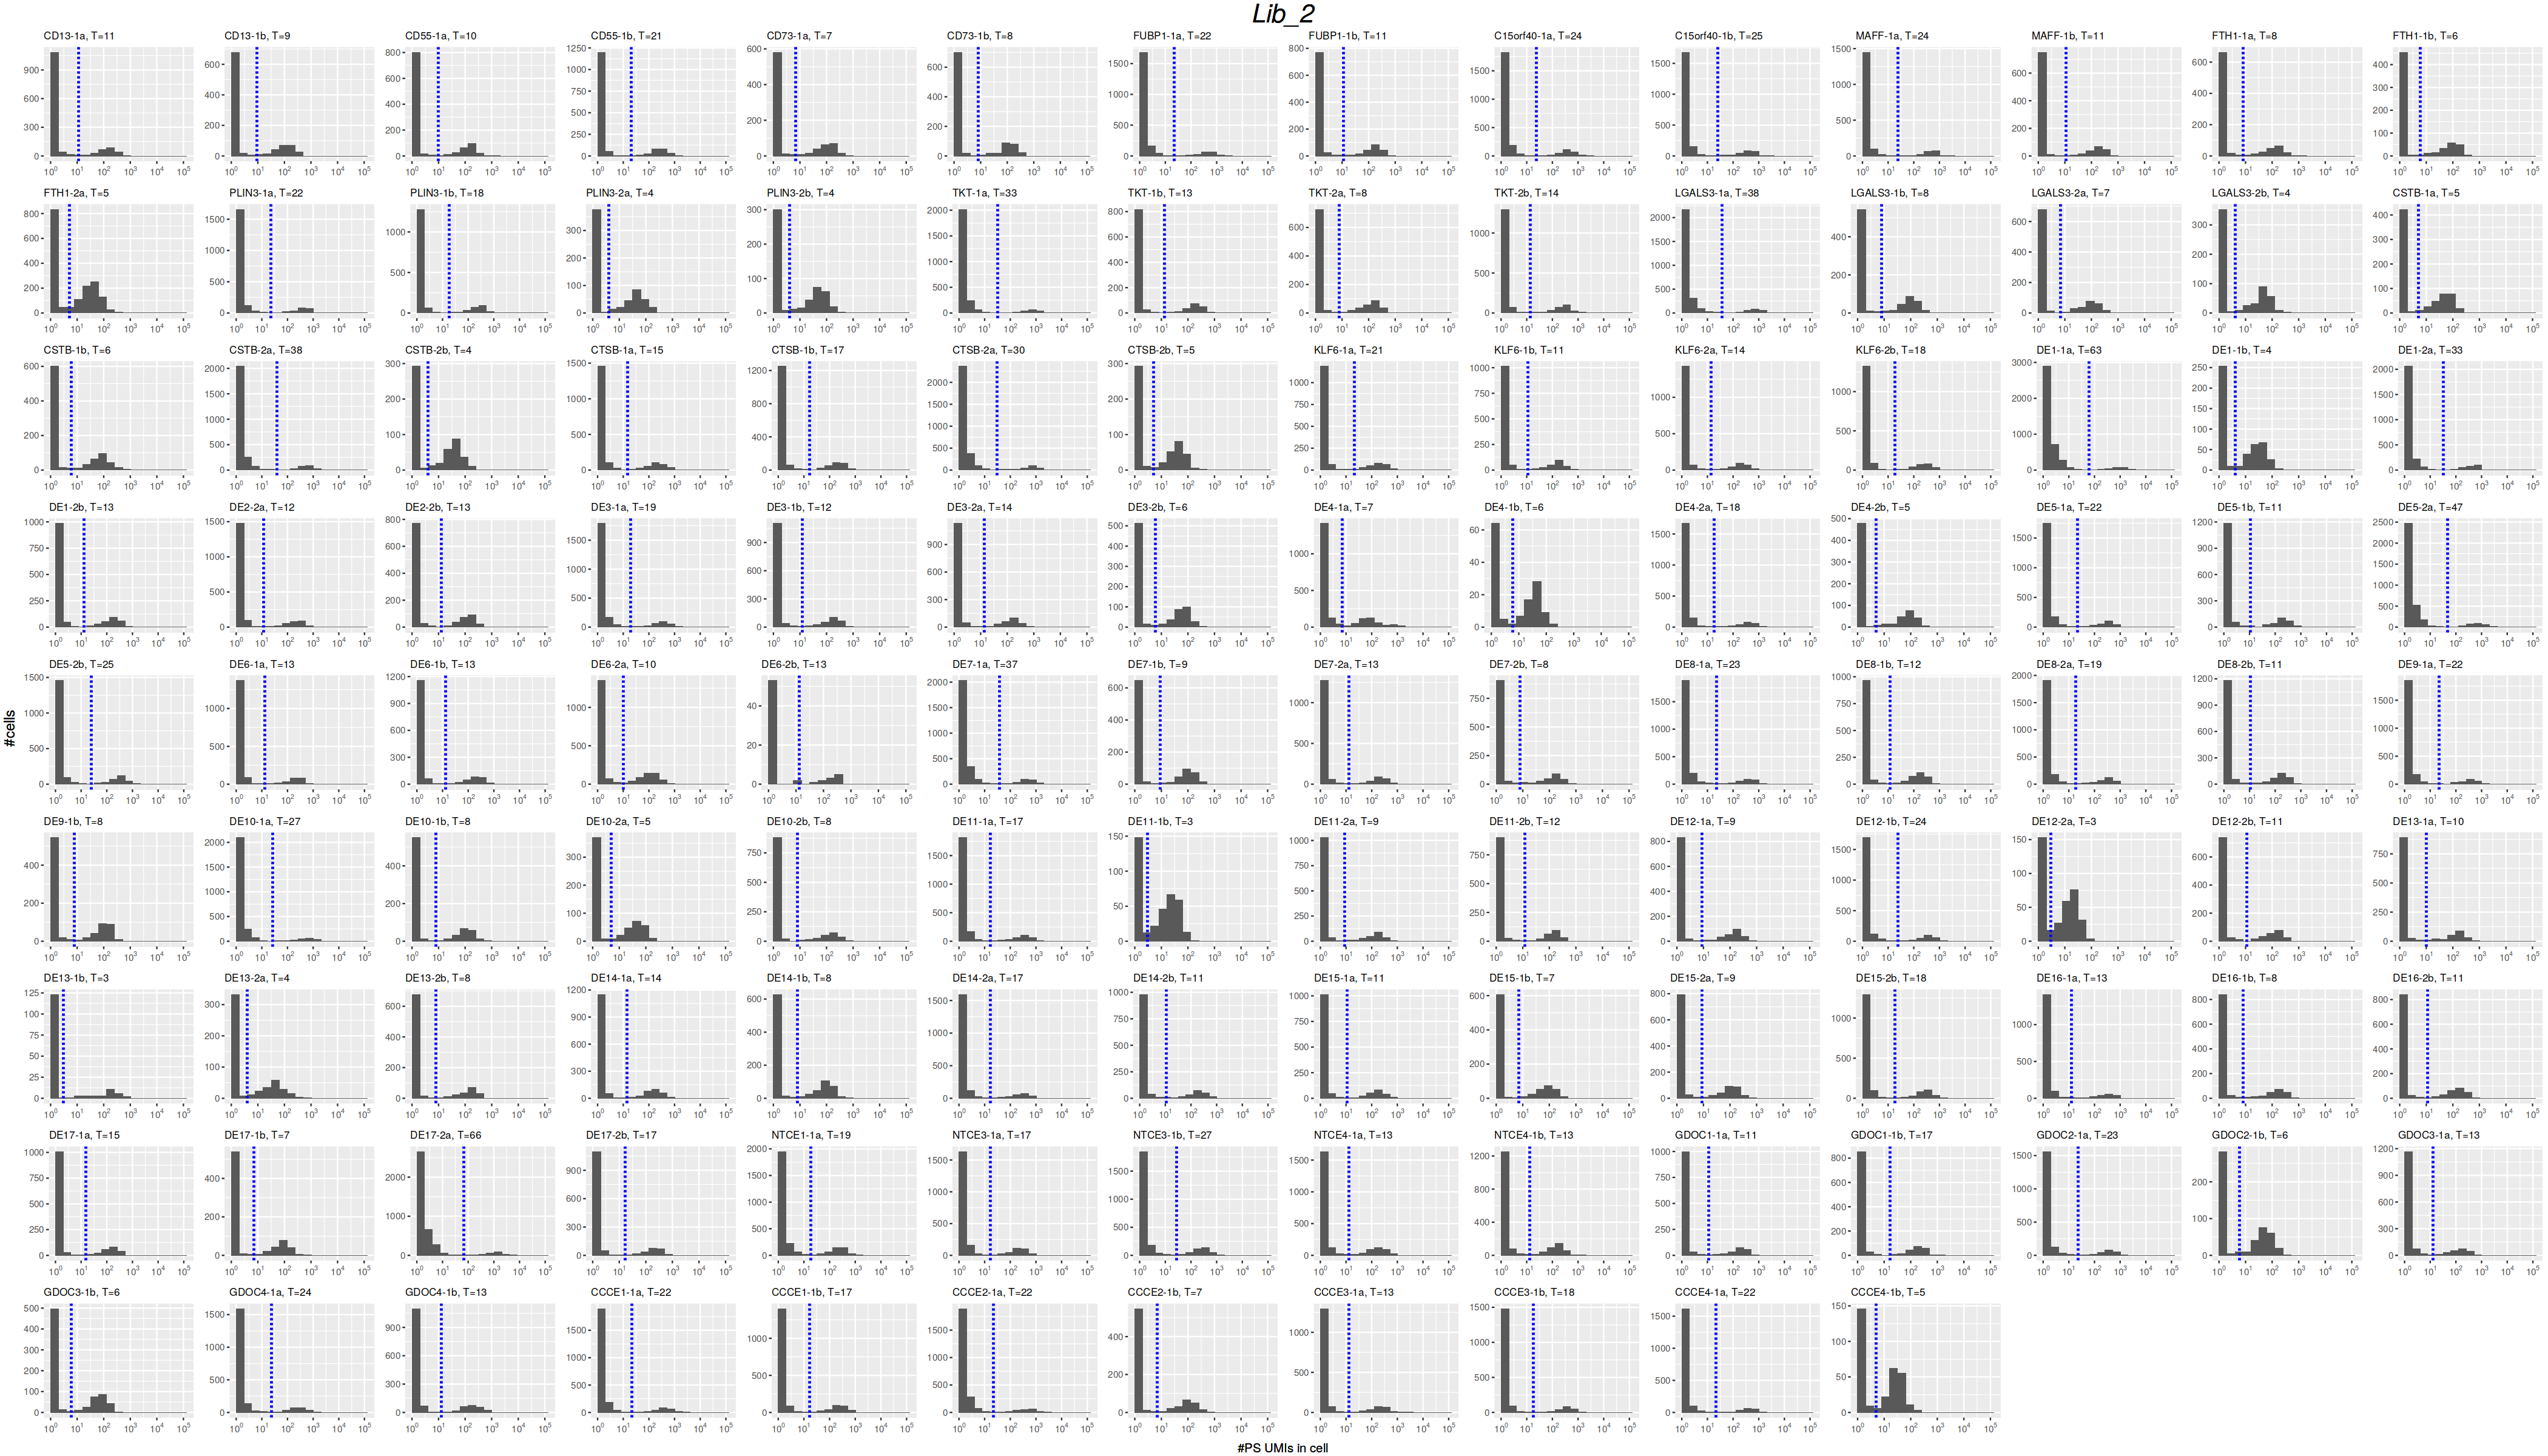

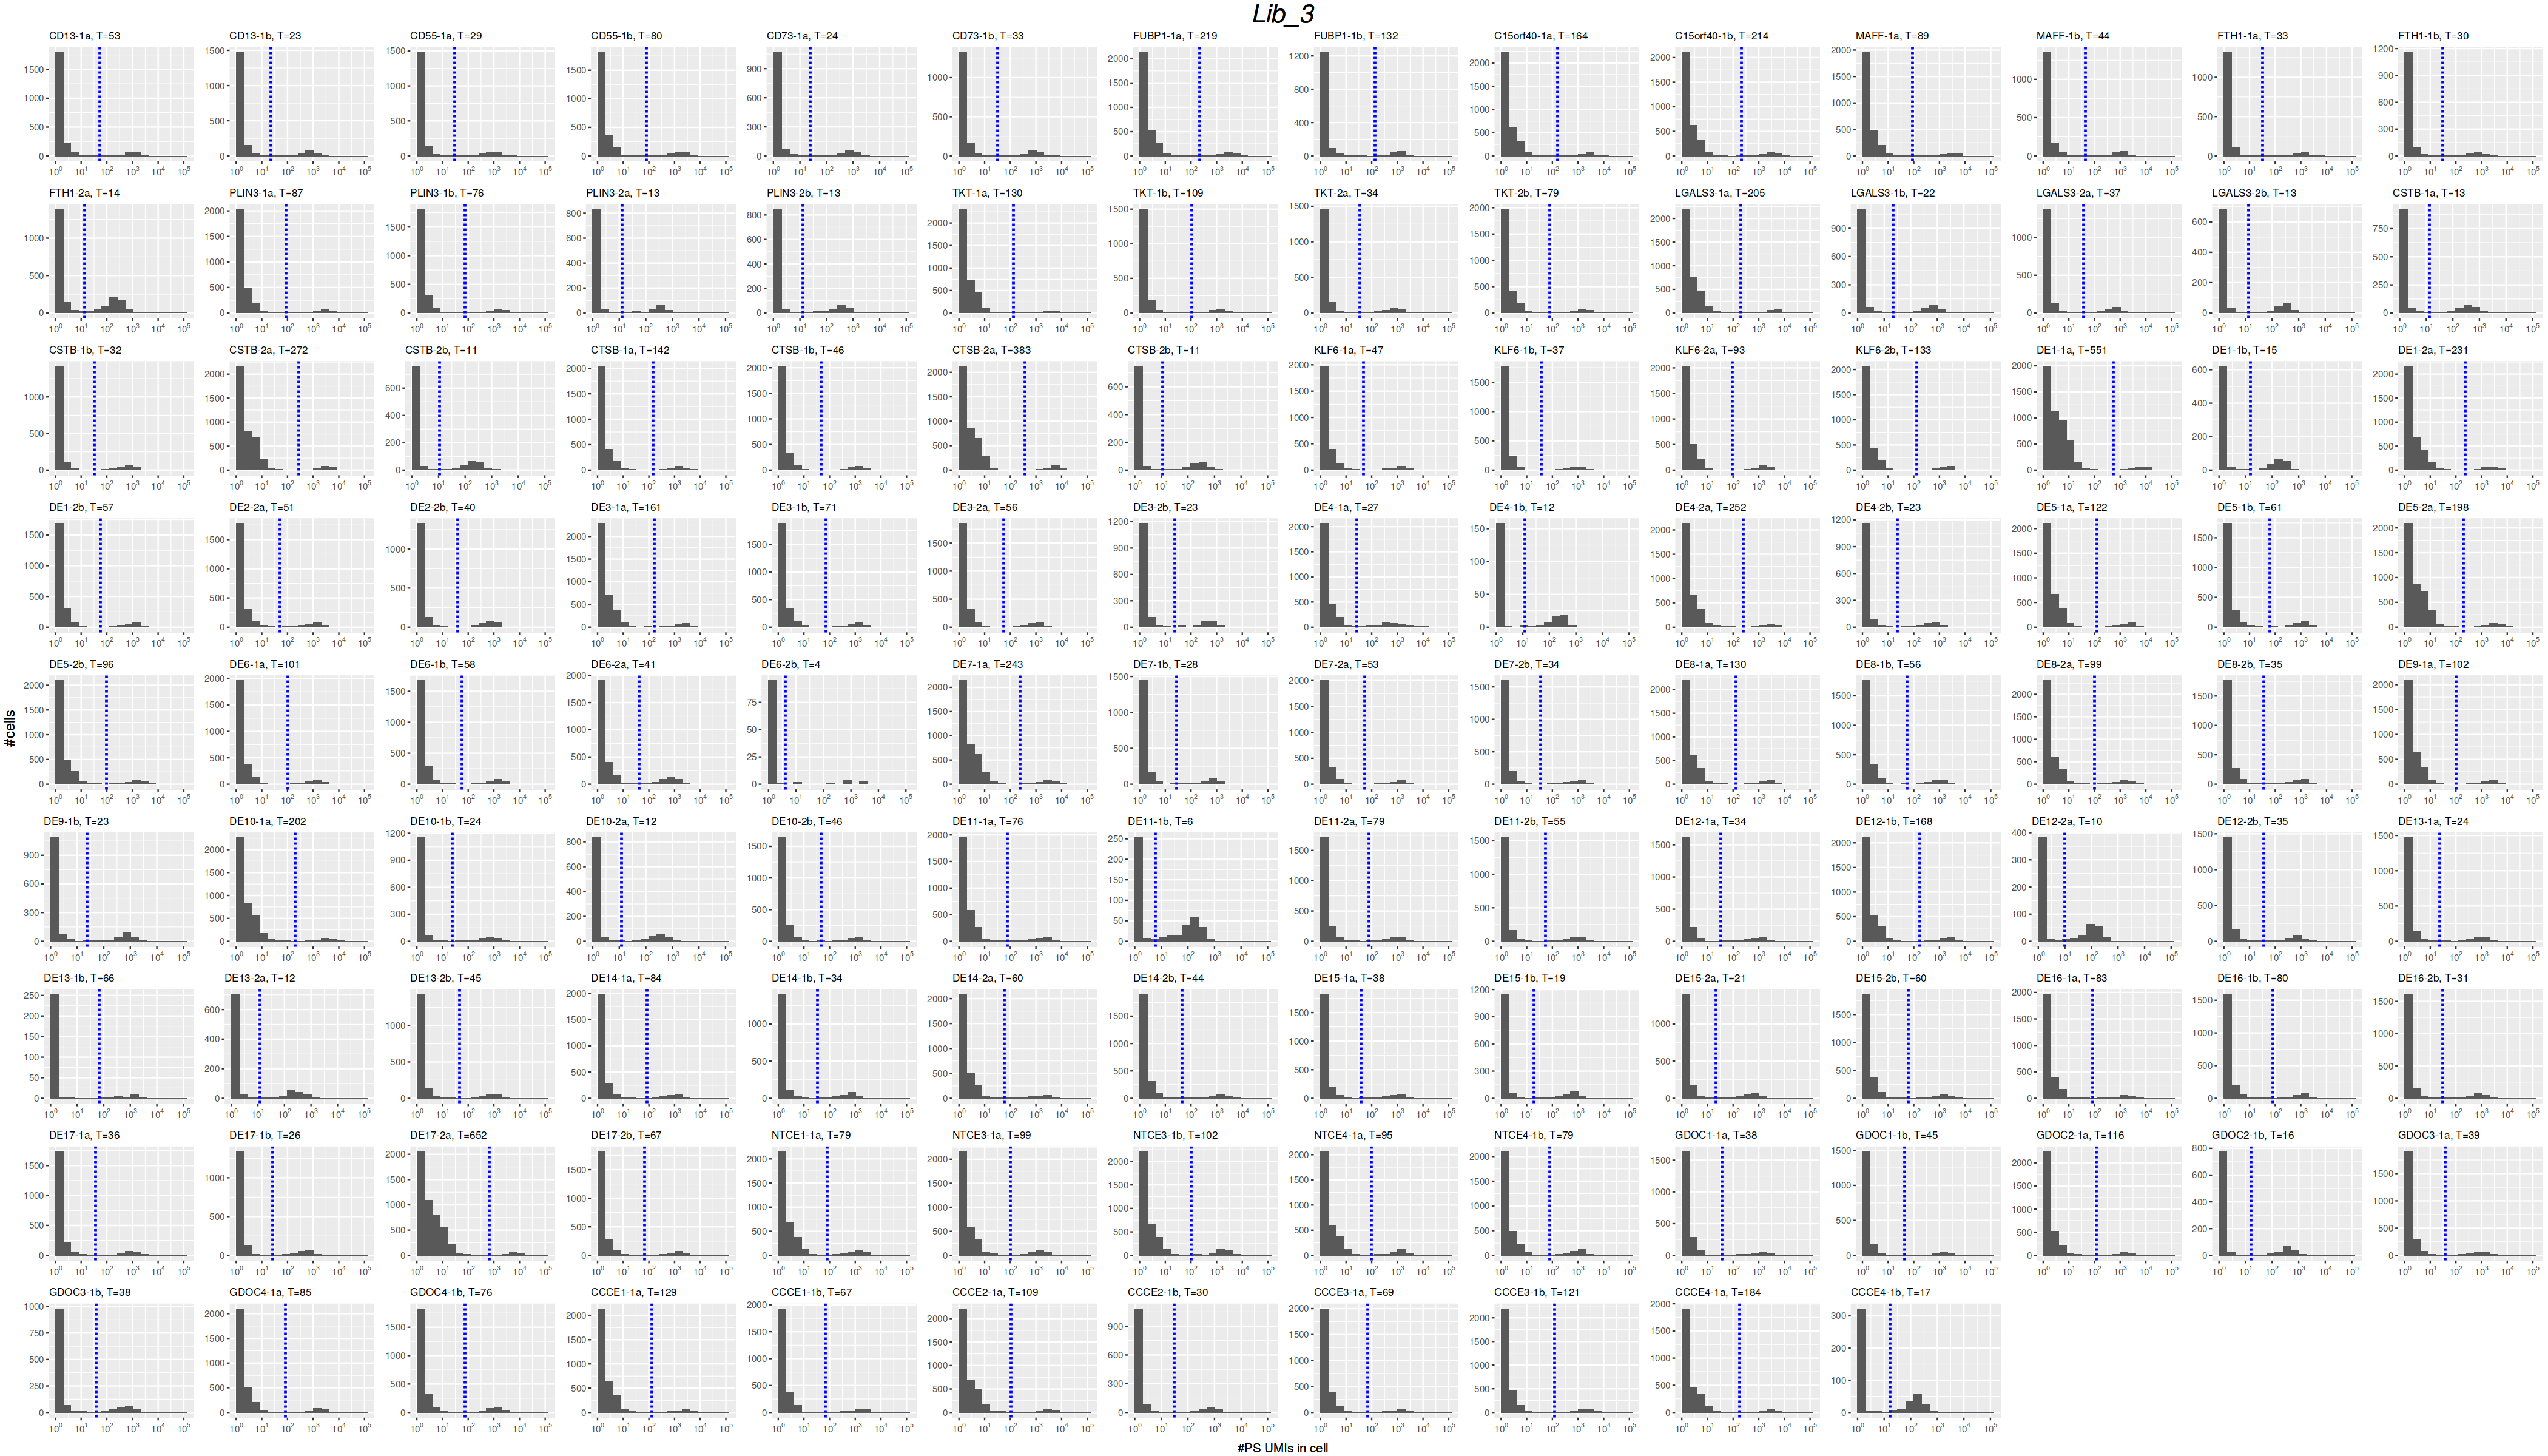

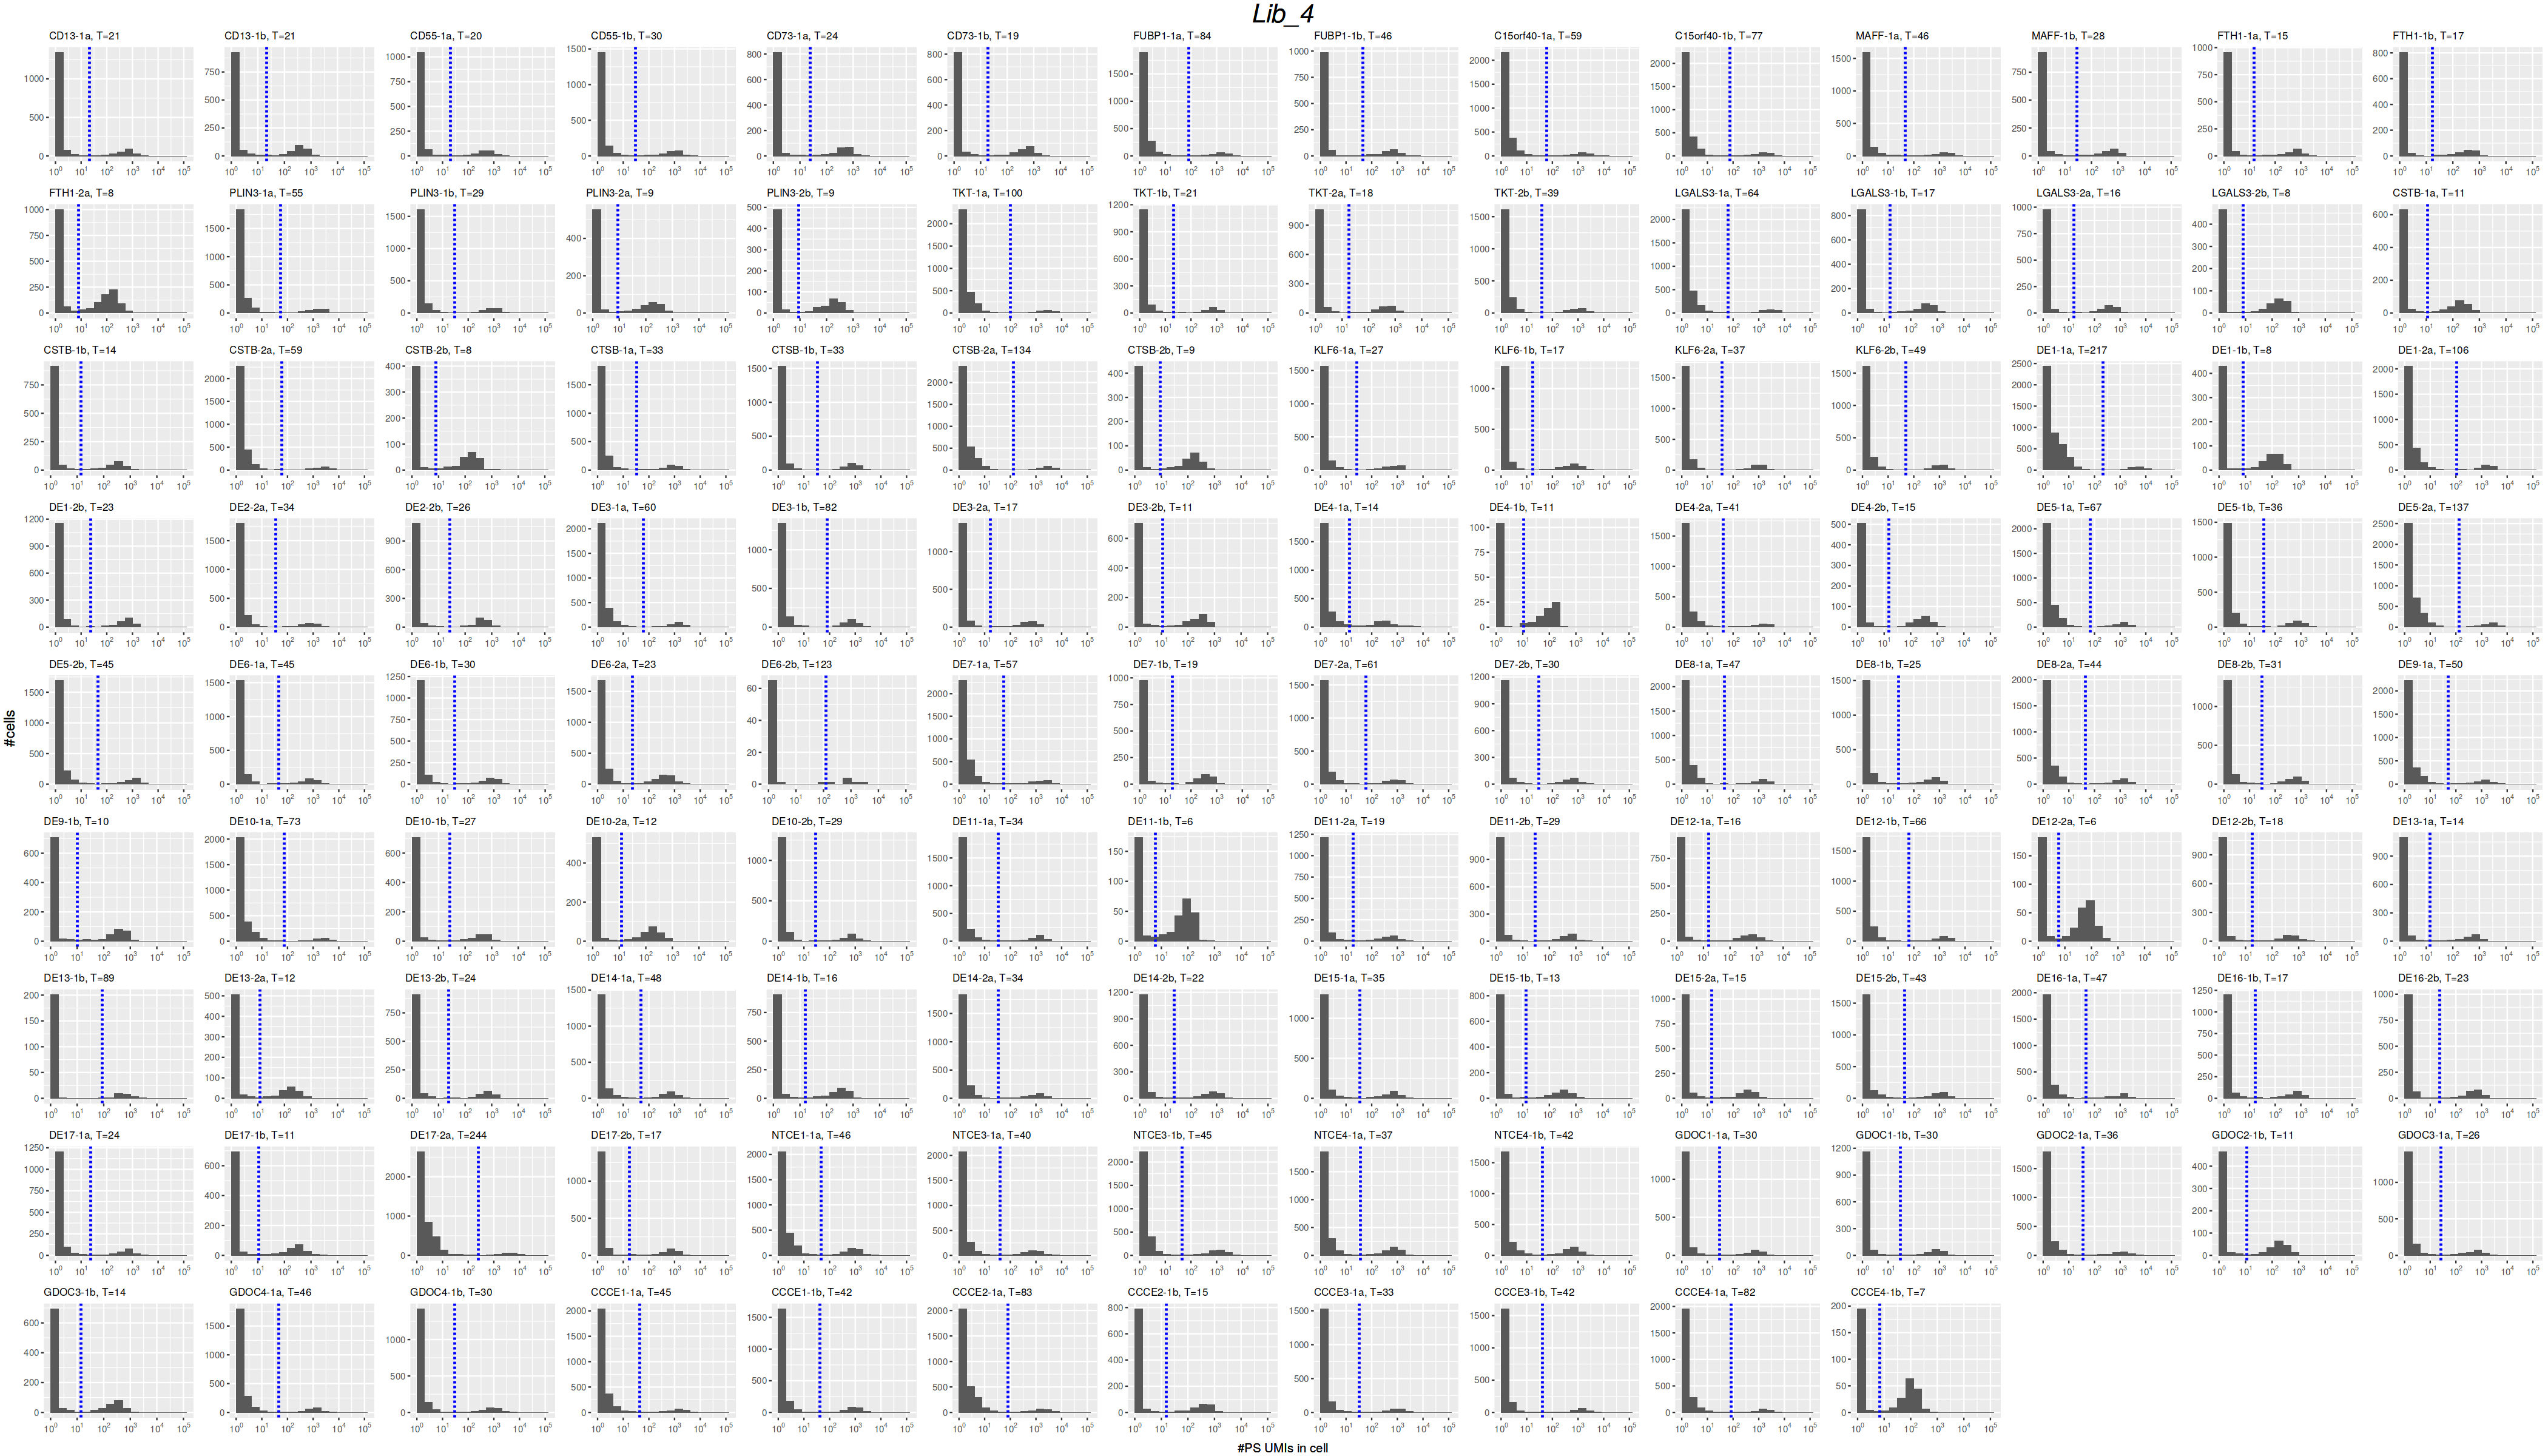

In [7]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB = 0.5
    guides = colnames(df_guide_counts)
    plots = list()

    for(i in seq_along(guides)) {
        guide = guides[[i]]
        y = df_guide_counts[,guide]
        select_nonzeros = y > 0
        y = y[select_nonzeros]
        if(length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            next
        }
        
        calls <- pgmix(y)
        df_calls = as.data.frame(calls)
        df_calls['counts'] = y
        colnames(df_calls) = c('call', 'prob', 'count')
        options(repr.plot.width=4, repr.plot.height=4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

        df_gauss = df_calls[select_gaussian_assigned,]
        dim(df_gauss)
        
        # head(df_gauss)
        threshold = min(df_gauss$count)
        #cat("threshold=", threshold)
        filter_y = y > 0
        y_filtered = y[filter_y]
        df_y = as.data.frame(y_filtered)
        head(df_y)
        
        options(repr.plot.width=3.3, repr.plot.height=2.4)
        bin_breaks <- c(1,2,2*2^(1:16))
        title = paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
            labs(title=title, x=NULL, y=NULL) +  
            geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
            theme(plot.title = element_text(size=10))

        plots <- append(plots, list(ggp1))
        index = nrow(df_thresholds) + 1
        df_thresholds[index,] <-  c(library_name, guide, threshold)
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width=35, repr.plot.height=20)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 14, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    pdf_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/guide_distr/"
    ggsave(
        file = paste0(pdf_path, library_name, "_guide_distributions.pdf"), 
        plt,
        width = 22, 
        height = 17, 
        dpi = 300
    )
}

# Write thresholds to file

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)

if(save_seurat_h5 == "YES") {
    write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)
}

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,15
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,13
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,9
6,Lib_1,CD73-1b,18


In [9]:
head(df_thresholds)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,15
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,13
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,9
6,Lib_1,CD73-1b,18


In [10]:
#head(seurat_combined@misc$stats)
rownames(seurat_combined@misc$stats) <- seurat_combined@misc$stats$Library

In [11]:
#head(seurat_combined)

In [12]:
nrow(seurat_combined@meta.data[seurat_combined@meta.data$library == 'Lib_1', ])
seurat  <- subset(seurat_combined, subset = library == 'Lib_1')
#DefaultAssay(seurat) <- "sgRNA"
nrow(seurat@meta.data)



[1] 7296

[1] 7296

# Update the Seurat object with Poission-Gaussian calls 

### Load thresholds

In [13]:
### Load THRESHOLDS.tsv
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)
### Load guide df
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS


### Get the list of pertubed cells for each guide

In [14]:
perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds)

In [15]:
df_calls = enframe(perturbed_cells_by_guide) %>% unnest(2)
df_calls = as.data.frame(df_calls)
df_calls$guide <- as.character(df_calls$name)
df_calls$cell  <- as.character(df_calls$value)
df_calls$name <- NULL
df_calls$value <- NULL
df_calls$plasmid <- sub(".$", "", df_calls$guide)

In [16]:
df_calls_wide <- df_calls %>% 
    group_by(cell) %>% 
    summarise(
        guide_calls = paste(unique(guide), collapse = '|'), 
        plasmid_calls = paste(unique(plasmid), collapse = '|')
    )

In [17]:
df_calls_wide$n_guides   <- str_count(df_calls_wide$guide_calls, "\\|") + 1
df_calls_wide$n_plasmids <- str_count(df_calls_wide$plasmid_calls, "\\|") + 1
df_calls_wide = as.data.frame(df_calls_wide)
rownames(df_calls_wide) <- df_calls_wide$cell
df_calls_wide$cell <- NULL

In [18]:
head(df_calls_wide,20)

,guide_calls,plasmid_calls,n_guides,n_plasmids
,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGAGGTCAC-1_3,DE14-2b|NTCE1-1a|GDOC4-1a,DE14-2|NTCE1-1|GDOC4-1,3,3
AAACCCAAGCCATTTG-1_4,DE2-2a,DE2-2,1,1
AAACCCAAGCCGATAG-1_4,NTCE1-1a,NTCE1-1,1,1
AAACCCAAGCTTAAGA-1_1,CD13-1a|CD13-1b|DE3-2a|DE3-2b,CD13-1|DE3-2,4,2
AAACCCAAGGCTGTAG-1_1,TKT-1a|TKT-1b,TKT-1,2,1
AAACCCAAGGTTTACC-1_1,DE9-1a|DE9-1b|DE11-1a,DE9-1|DE11-1,3,2
AAACCCACAAATAAGC-1_3,CSTB-1a|CSTB-1b|DE5-1a|DE5-1b|DE14-2a|DE14-2b|NTCE4-1a|NTCE4-1b,CSTB-1|DE5-1|DE14-2|NTCE4-1,8,4
AAACCCACAAGCTCTA-1_4,DE5-1b|DE12-1a|DE12-1b|CCCE1-1a,DE5-1|DE12-1|CCCE1-1,4,3


### Update the Seurat object with Poisson-Gaussian guide calls

Update the Seurat object

In [19]:
seurat_backup = seurat_combined

In [20]:
cols2rename = c('PS_call', 'construct_call', 'target_call', 'nCalled_Constructs', 'nPS_calls', 'nCalled_sgRNA_UMIs')
df_dummy = seurat_combined@meta.data
for(i in 1:length(cols2rename)) {
    colname = cols2rename[i]
    names(df_dummy)[names(df_dummy) == colname] <- paste0('cellranger_', colname) 
}

In [21]:
df_dummy = merge(df_dummy, df_calls_wide, by = 0, all.x = T)
rownames(df_dummy) <- df_dummy$Row.names
df_dummy$Row.names <- NULL
original_row_names <- rownames(seurat_combined@meta.data)
seurat_combined@meta.data = df_dummy[original_row_names,]

In [22]:
nrow(seurat_backup@meta.data)
nrow(seurat_combined@meta.data)
nrow(df_dummy)

[1] 27309

[1] 27309

[1] 27309

How many cells with no calls?

In [23]:
sum(is.na(seurat_combined$n_plasmids))

[1] 6442

In [24]:
sum(rownames(seurat_combined) != rownames(seurat_backup))

[1] 0

In [25]:
nrow(df_calls_wide)
length(Cells(seurat_combined))

[1] 20867

[1] 27309

No-call cells are really not in df_calls_wide?

In [26]:
no_call_cells = rownames(seurat_combined@meta.data[is.na(seurat_combined$n_plasmids), ])
intersect(rownames(df_calls_wide), no_call_cells)

character(0)

### Add guide-called cell counts to the Misc slot

In [27]:
call_counts = c()
for(lib in rownames(seurat_combined@misc$stats)) {
    print(lib)
    seurat <- subset(seurat_combined, subset = library == lib)
    n_cells_w_a_plasmid_call = sum(seurat$n_plasmids >= 1 & !is.na(seurat$n_plasmids)) 
    call_counts = c(call_counts, n_cells_w_a_plasmid_call)    
}
seurat_combined@misc$stats$cells_w_a_plasmid = call_counts

[1] "Lib_1"
[1] "Lib_2"
[1] "Lib_3"
[1] "Lib_4"


In [28]:
df_stats = seurat_combined@misc$stats
stats_out_path <- paste0(secondary_a_path, "/stats/")
stats_fname = paste0(stats_out_path, "ALL_STATS.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(df_stats, file=stats_fname, quote=FALSE, sep='\t', col.names = NA)

In [29]:
stats_fname

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary//stats/ALL_STATS.tsv"

### Save the updated Seurat object

In [30]:
if(save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat_combined, updated_integrated_h5_path, overwrite = T, verbose = F)
}

Warning message:
"Overwriting previous file /home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
Creating h5Seurat file for version 3.1.5.9900



# Visualizations using the PG guide-called data

### Constructs per cell distribution

In [31]:
table(df_calls_wide$n_plasmids)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
5929 4657 3097 2123 1453  942  679  481  316  228  180  110  114   92   70   54 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  57   36   31   33   24   21   25   21    8   13    7    8    8    4    9    4 
  33   34   35   36   37   38   39   40   41   42   44   47 
   4    4    2    4    4    3    2    3    3    2    1    1 

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 4 rows containing missing values (`geom_bar()`)."


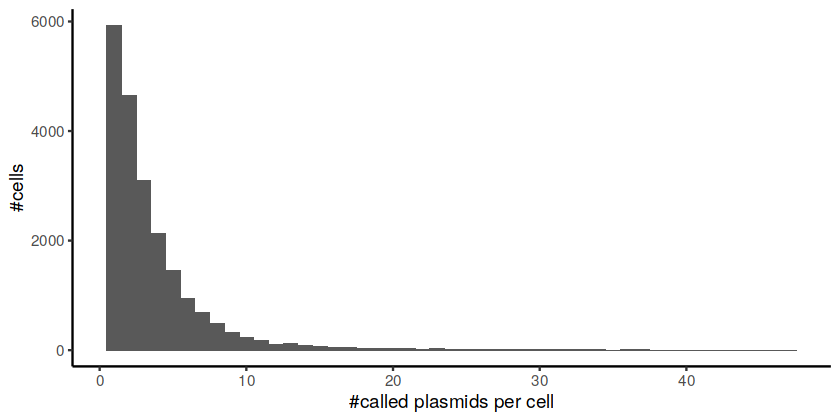

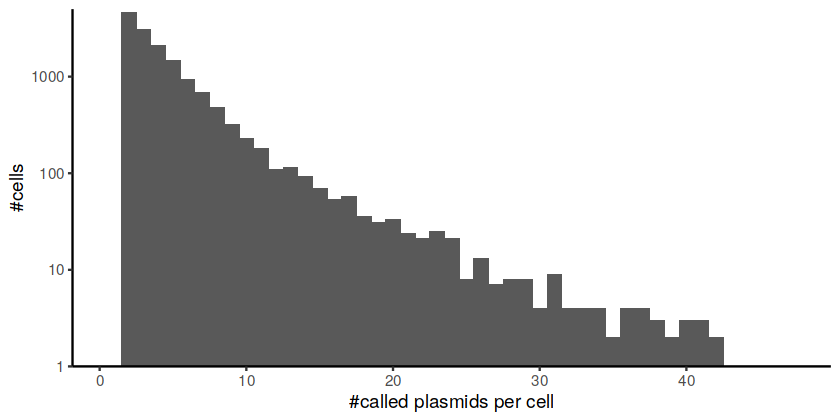

In [32]:
p5 <- ggplot(df_calls_wide, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") + 
    theme_classic() 

p6 <- ggplot(df_calls_wide, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    scale_y_log10(limits = c(1, 5000), expand = c(0, 0)) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") +
    theme_classic() 

options(repr.plot.width=7, repr.plot.height=3.5)
p5
p6

### Plot cells per plasmid distribution

In [33]:
plasmid_calls = seurat_combined@meta.data$plasmid_calls
plasmid_calls = str_split(paste0(plasmid_calls, collapse = "|"), "\\|")
df_dummy = as.data.frame(table(plasmid_calls))
df_dummy$plasmid_calls = as.character(df_dummy$plasmid_calls)
df_dummy[df_dummy$plasmid_calls == "NA", 'plasmid_calls'] = " No Plasmid"

In [34]:
head(df_dummy, 20)

,plasmid_calls,Freq
,<chr>,<int>
1,C15orf40-1,1085
2,CCCE1-1,1185
3,CCCE2-1,1076
4,CCCE3-1,971
5,CCCE4-1,809
6,CD13-1,1168
7,CD55-1,1084
8,CD73-1,1026
9,CSTB-1,1259


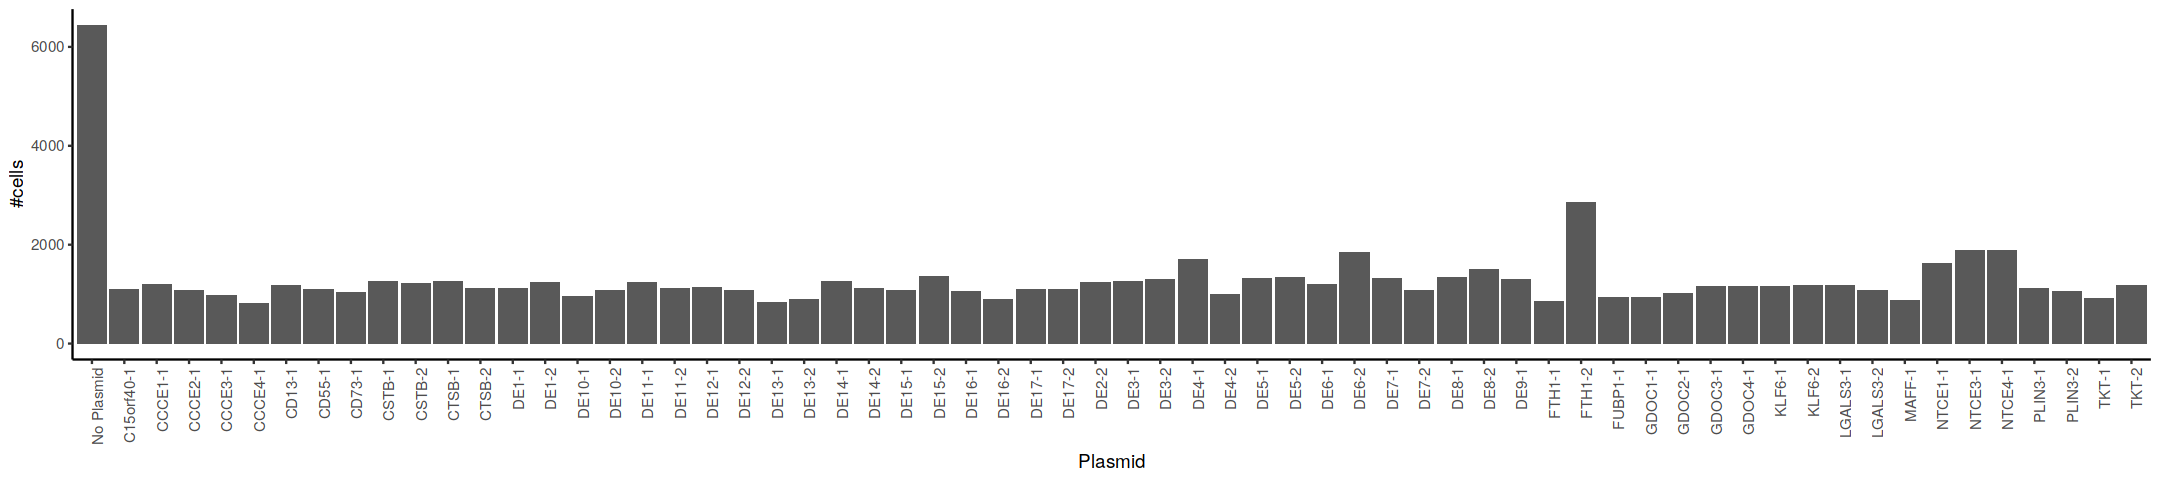

In [35]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6

In [36]:
df_dummy = df_dummy[df_dummy$plasmid_calls != " No Plasmid", ] 

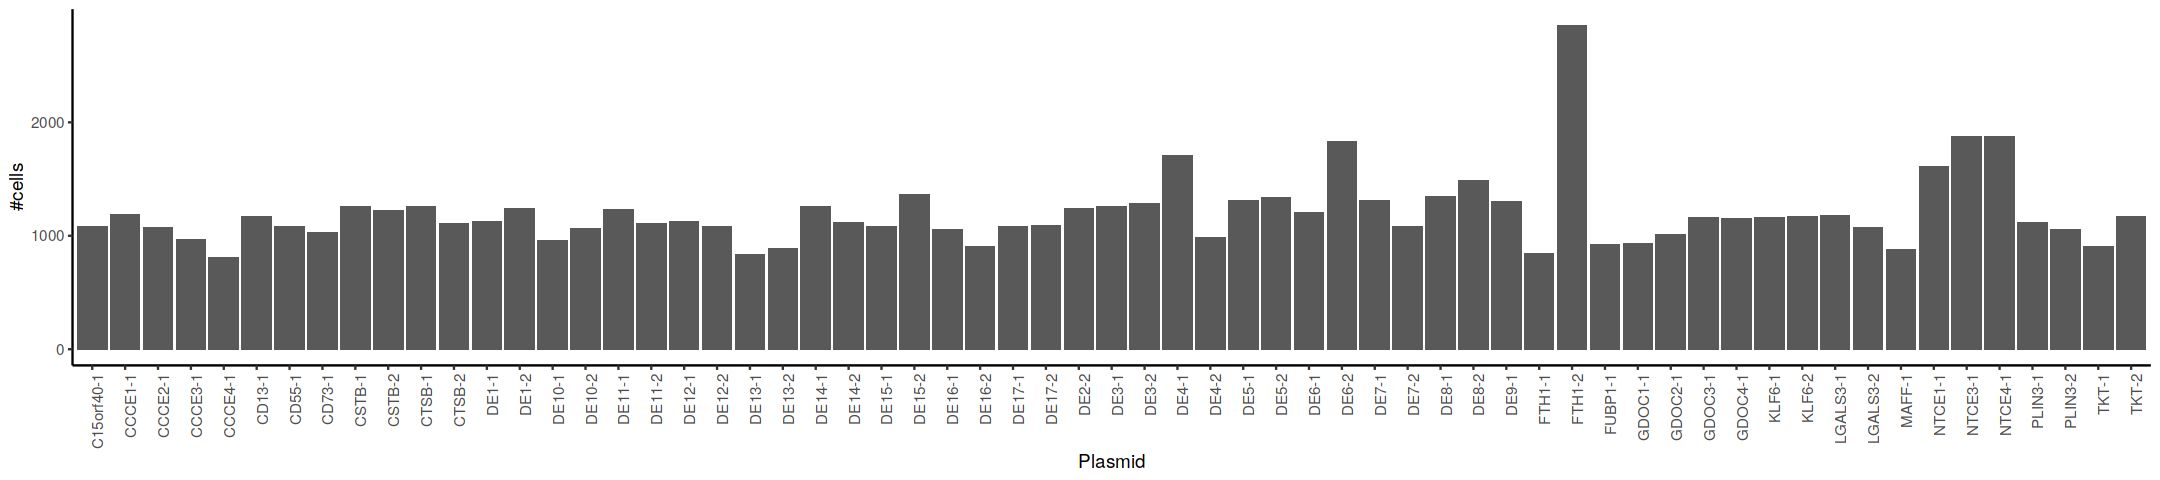

In [37]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6

Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


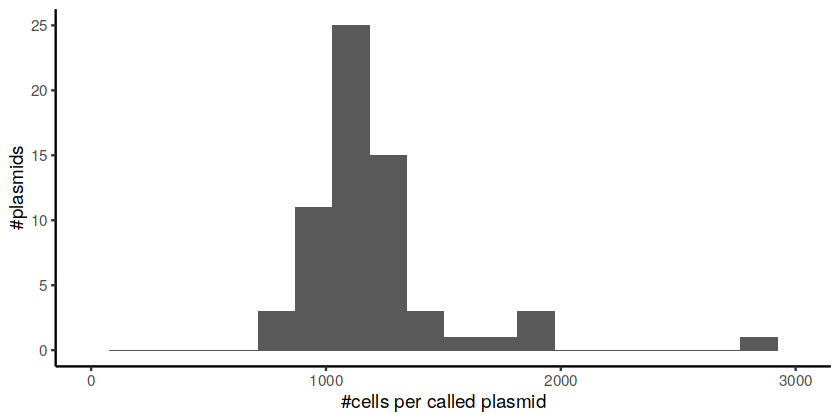

In [38]:
options(repr.plot.width=7, repr.plot.height=3.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    xlim(-1,3000) +
    theme_classic() 
    

In [39]:
length(Cells(subset(seurat_combined, subset=library=='Lib_2')))

[1] 7589

# Stats

In [40]:
df_stats = seurat_combined@misc$stats
t(df_stats)


,Lib_1,Lib_2,Lib_3,Lib_4
Cells_after_QC_filtering,8015,8628,6401,7203
Cells_recovered,9169,9443,7113,8015
Cells_with_sgRNA_count_less_than_100,1786,2250,1158,1573
Doublets_in_filtered_cells,718,1033,512,665
Genes_recovered,31847,30856,29531,31390
Library,Lib_1,Lib_2,Lib_3,Lib_4
Max_mito_perc_threshold,17,18,17,17
Max_n_RNA_threshold,98264,52856,34198,79578
Max_n_genes_threshold,12173,9736,8024,11188
Min_mito_perc_threshold,3,3,3,3


# Debug

In [41]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [42]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined, df_thresholds)

In [43]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 915

[1] 915

In [44]:
length(perturbed_cells_by_guide$'DE6-1b')

[1] 915

In [45]:
nrow(seurat_combined)

[1] 29745

In [46]:
unique(seurat_combined$status)

[1] "singlet"

In [47]:
table(seurat_combined$library)


Lib_1 Lib_2 Lib_3 Lib_4 
 7296  7589  5886  6538 

In [48]:
length(perturbed_cells_by_guide$'FTH1-1a')

[1] 630

In [49]:
length(unlist(perturbed_cells_by_guide))

[1] 109545

### ---

In [50]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined_debug    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
#seurat_combined_debug    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


In [51]:
libraries = unique(seurat_combined_debug$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined_debug, subset = library == lib)
}
names(seurat_libs) <- libraries

In [52]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined_debug, df_thresholds)

In [53]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 915

[1] 915

In [54]:
sum(rowSums(seurat_combined_debug[['sgRNA']]@counts)) - sum(rowSums(seurat_combined[['sgRNA']]@counts))

[1] 0

In [55]:
colSums(seurat_combined_debug@meta.data != seurat_combined@meta.data)

nCount_RNA    nFeature_RNA    nCount_sgRNA  nFeature_sgRNA      nCount_SCT 
              0               0               0               0               0 
   nFeature_SCT      orig.ident         library      percent.mt          status 
              0               0               0               0               0 
          donor SCT_snn_res.0.5 seurat_clusters     guide_calls   plasmid_calls 
              0               0               0              NA              NA 
       n_guides      n_plasmids 
             NA              NA